# Documentation tutorial

In [1]:
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.algorithms import NumPyMinimumEigensolver

In [2]:
num_nodes = 4
w = np.array([[0., 1., 1., 0.],
              [1., 0., 1., 1.],
              [1., 1., 0., 1.],
              [0., 1., 1., 0.]])

G = nx.from_numpy_matrix(w)

{(0, 1): Text(0.7024844288825989, 0.3847779016941786, '1.0'),
 (0, 2): Text(0.634913831949234, 0.12277430109679699, '1.0'),
 (1, 2): Text(0.5660776197910309, 0.48680025339126587, '1.0'),
 (1, 3): Text(0.4158555418252945, 0.7546672821044922, '1.0'),
 (2, 3): Text(0.3482849448919296, 0.4926636815071106, '1.0')}

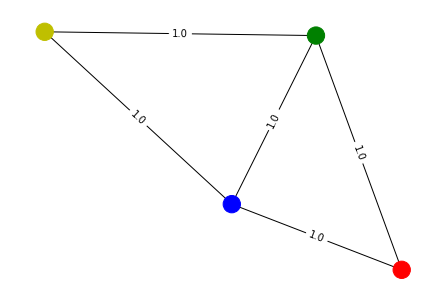

In [3]:
layout = nx.random_layout(G,seed = 10)
colors = ['r','g','b','y']
nx.draw(G,layout, node_color = colors)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos = layout, edge_labels=labels)

In [4]:
def objective_value(x,w):
    X = np.outer(x,(1-x))
    w_01 = np.where( w != 0, 1,0)
    return np.sum(w_01*X)
    
def brute_force():
    def bitfield(n,L):
        result = np.binary_repr(n,L)
        return [int(digit) for digit in result]
    L = num_nodes
    max = 2**L
    minimal_v = np.inf
    for i in range(max):
        cur = bitfield(i,L)
        how_many_nonzero = np.count_nonzero(cur)
        if how_many_nonzero*2 != L:
            continue
        cur_v = objective_value(np.array(cur),w)
        if cur_v < minimal_v:
            minimal_v = cur_v
    return minimal_v

sol = brute_force()
print(f'Objective value computed by the brute-force method is {sol}')

Objective value computed by the brute-force method is 3


In [5]:
from qiskit.quantum_info import Pauli
from qiskit.opflow import PauliSumOp

def get_operator(weight_matrix):
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 separate the vertices into two set of the same size
            2 make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix (numpy.ndarray) : adjacency matrix.
    Returns:
        PauliSumOp: operator for the Hamiltonian
        float: a constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    shift = 0
    
    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i,j] !=0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append([-0.5, Pauli((z_p,x_p))])
                shift += 0.5
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i!=j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append([1,Pauli((z_p,x_p))])
            else:
                shift += 1
    print("Before : ",pauli_list)
    pauli_list = [(pauli[1].to_label(), pauli[0]) for pauli in pauli_list]
    print("After : ",pauli_list)
    
    return PauliSumOp.from_list(pauli_list), shift
qubit_op, offset = get_operator(w)

print("qbuti_op = \n",qubit_op)
print("offset = ",offset)

Before :  [[-0.5, Pauli('IIZZ')], [-0.5, Pauli('IZIZ')], [-0.5, Pauli('IZZI')], [-0.5, Pauli('ZIZI')], [-0.5, Pauli('ZZII')], [1, Pauli('IIZZ')], [1, Pauli('IZIZ')], [1, Pauli('ZIIZ')], [1, Pauli('IIZZ')], [1, Pauli('IZZI')], [1, Pauli('ZIZI')], [1, Pauli('IZIZ')], [1, Pauli('IZZI')], [1, Pauli('ZZII')], [1, Pauli('ZIIZ')], [1, Pauli('ZIZI')], [1, Pauli('ZZII')]]
After :  [('IIZZ', -0.5), ('IZIZ', -0.5), ('IZZI', -0.5), ('ZIZI', -0.5), ('ZZII', -0.5), ('IIZZ', 1), ('IZIZ', 1), ('ZIIZ', 1), ('IIZZ', 1), ('IZZI', 1), ('ZIZI', 1), ('IZIZ', 1), ('IZZI', 1), ('ZZII', 1), ('ZIIZ', 1), ('ZIZI', 1), ('ZZII', 1)]
qbuti_op = 
 -0.5 * IIZZ
- 0.5 * IZIZ
- 0.5 * IZZI
- 0.5 * ZIZI
- 0.5 * ZZII
+ 1.0 * IIZZ
+ 1.0 * IZIZ
+ 1.0 * ZIIZ
+ 1.0 * IIZZ
+ 1.0 * IZZI
+ 1.0 * ZIZI
+ 1.0 * IZIZ
+ 1.0 * IZZI
+ 1.0 * ZZII
+ 1.0 * ZIIZ
+ 1.0 * ZIZI
+ 1.0 * ZZII
offset =  6.5


In [19]:
from collections import OrderedDict
from qiskit.utils import algorithm_globals
from qiskit.algorithms import QAOA
from qiskit.opflow import StateFn
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal

def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector (numpy.ndarray or dict): state vector or counts.
    Returns:
        numpy.ndarray: binary string as numpy.ndarray of ints.
    """
    if isinstance(state_vector, (OrderedDict, dict)):
        binary_string = sorted(state_vector.items(), key=lambda kv: kv[1])[-1][0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    elif isinstance(state_vector, StateFn):
        binary_string = list(state_vector.sample().keys())[0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    else:
        n = int(np.log2(state_vector.shape[0]))
        k = np.argmax(np.abs(state_vector))
        x = np.zeros(n)
        for i in range(n):
            x[i] = k%2
            k >>=1
        return x
    

    
# algorithm_globals.random_seed = 10598
optimizer = COBYLA()
qaoa = QAOA(optimizer, quantum_instance=Aer.get_backend('qasm_simulator'), shots=1024)

result = qaoa.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f'Objective value computed by QAOA is {objective_value(x, w)}')
    

TypeError: __init__() got an unexpected keyword argument 'shots'

In [14]:
result_list = []
for i in range(100):
    result = qaoa.compute_minimum_eigenvalue(qubit_op)
    x = sample_most_likely(result.eigenstate)
    result_list.append(objective_value(x,w))
import matplotlib.pyplot as plt



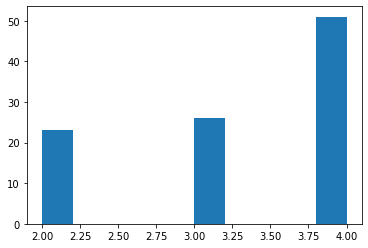

In [15]:
plt.hist(result_list)
plt.show()

In [46]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(qubit_op)
x = sample_most_likely(result.eigenstate)

print(x)
print(f'Objective value computed by the NumPyMinimumEigensolver is {objective_value(x, w)}')

[1 1 0 0]
Objective value computed by the NumPyMinimumEigensolver is 3


In [47]:
from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal

algorithm_globals.random_seed = 10598
optimizer = COBYLA()
ansatz = TwoLocal(qubit_op.num_qubits, 'ry','cz', reps = 5, entanglement = 'linear')

vqe = VQE(ansatz,optimizer,quantum_instance=Aer.get_backend('statevector_simulator'))
result = vqe.compute_minimum_eigenvalue(qubit_op)
x = sample_most_likely(result.eigenstate)

print(x)
print(f'Objective value computed by VQE is {objective_value(x, w)}')

[0. 1. 0. 1.]
Objective value computed by VQE is 3.0


# Textbook tutorial

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

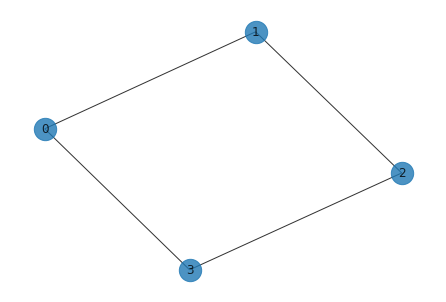

In [21]:

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

### Mixing unitary

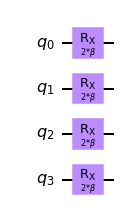

In [24]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw(output='mpl')

### Problem unitary / Cost Hamiltonian

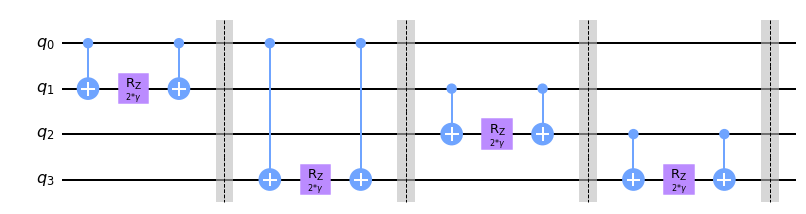

In [25]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw(output='mpl')

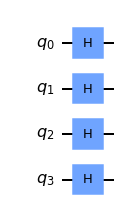

In [26]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)

qc_0.draw(output = 'mpl')

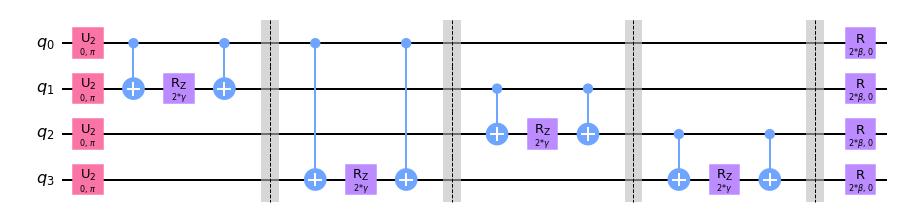

In [27]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw(output = 'mpl')

In [28]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

In [31]:
def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [32]:
# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

In [33]:
# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [36]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1, shots = 1024)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

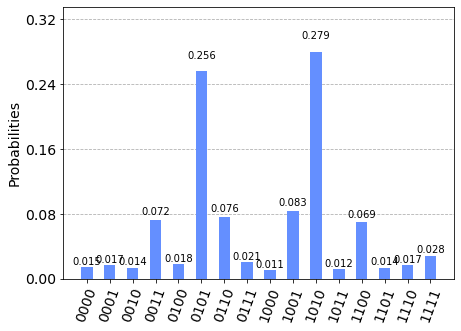

In [46]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res).result().get_counts()

plot_histogram(counts)